<a href="https://colab.research.google.com/github/jaronsander/sip_data/blob/main/fall_detection_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Venture Design 2022 b5 fall detection



In [2]:
## import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchaudio
import pandas as pd
import os
from sklearn.model_selection import KFold
import librosa

In [3]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!git clone https://github.com/jaronsander/sip_data.git

Cloning into 'sip_data'...
remote: Enumerating objects: 25981, done.
remote: Counting objects: 100% (9954/9954), done.
remote: Compressing objects: 100% (9942/9942), done.
remote: Total 25981 (delta 14), reused 9946 (delta 10), pack-reused 16027
Receiving objects: 100% (25981/25981), 3.00 GiB | 27.12 MiB/s, done.
Resolving deltas: 100% (568/568), done.
Updating files: 100% (14386/14386), done.


# Dataset Loader

In [4]:
class FallDataset(Dataset):
  def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate,num_samples,device):
    self.annotations = pd.read_csv(annotations_file)
    self.audio_dir = audio_dir
    self.device = device
    self.transformation = transformation.to(self.device)
    self.target_sample_rate = target_sample_rate
    self.num_samples = num_samples
  def _cut_if_necessary(self, signal):
    if signal.shape[1] > self.num_samples:
        signal = signal[:, :self.num_samples]
    return signal

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    audio_sample_path = self._get_audio_sample_path(index)
    label = self._get_audio_sample_label(index)
    # print(torchaudio.info(audio_sample_path))
    signal, sr = torchaudio.load(audio_sample_path, channels_first=True)
    signal = signal.to(self.device)
    signal = signal[0:2]

    # print(signal.shape)
    # signal = self._resample_if_necessary(signal[1:3], sr)
    # signal = self._mix_down_if_necessary(signal)
    signal = self._cut_if_necessary(signal)
    signal = self._right_pad_if_necessary(signal)
    signal = self.transformation(signal)
    return signal, label

  def _right_pad_if_necessary(self, signal):
    length_signal = signal.shape[1]
    if length_signal < self.num_samples:
        num_missing_samples = self.num_samples - length_signal
        last_dim_padding = (0, num_missing_samples)
        signal = torch.nn.functional.pad(signal, last_dim_padding)
    return signal

  def _resample_if_necessary(self, signal, sr):
    if sr != self.target_sample_rate:
        resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
        resampler.to(self.device)
        signal = resampler(signal)
    return signal

  def _mix_down_if_necessary(self, signal):
    if signal.shape[0] > 1:
        signal = torch.mean(signal, dim=0, keepdim=True)
    return signal

  def _get_audio_sample_path(self, index):
    fold = self.annotations.iloc[index, 2]
    path = os.path.join(self.audio_dir, fold, self.annotations.iloc[
        index, 1])
    return path

  def _get_audio_sample_label(self, index):
    return self.annotations.iloc[index, 3]

## Test dataset loader

In [5]:
import librosa
import matplotlib.pyplot as plt
#from IPython.display import Audio
def plot_spectrogram(audio, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title("Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(audio.cpu()), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

Using device cuda
There are 3746 samples in the dataset.
torch.Size([2, 64, 130])
1


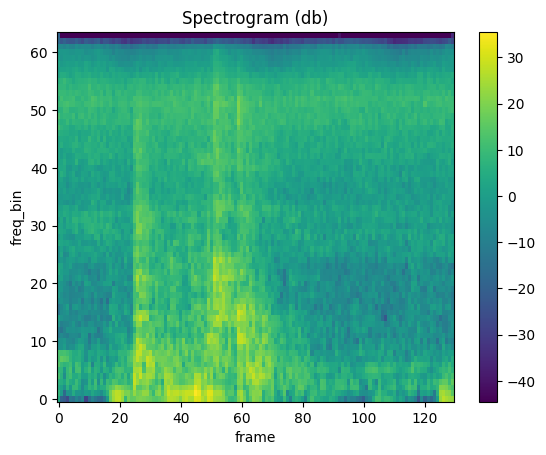

In [6]:
ANNOTATIONS_FILE = "/content/sip_data/fall_annotations.csv"
AUDIO_DIR = "/content/sip_data/"
SAMPLE_RATE = 22050*2
NUM_SAMPLES = int(SAMPLE_RATE*1.5)
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")
hop_length = 512
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=hop_length,
    n_mels=64
)
usd = FallDataset(ANNOTATIONS_FILE,
                            AUDIO_DIR,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            device)
print(f"There are {len(usd)} samples in the dataset.")
train_dataloader = DataLoader(usd, batch_size=256, shuffle=True)

signal, label = usd[2850]
print(signal.shape)
print(label)
plot_spectrogram(signal[0])

# CNN

In [ ]:
from torch import nn
from torchsummary import summary


class CNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(3200*2, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions


if __name__ == "__main__":
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using device {device}")
    cnn = CNNNetwork()
    summary(cnn.to(device), (1, 64, 65*2))

Using device cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 66, 132]             160
              ReLU-2          [-1, 16, 66, 132]               0
         MaxPool2d-3           [-1, 16, 33, 66]               0
            Conv2d-4           [-1, 32, 35, 68]           4,640
              ReLU-5           [-1, 32, 35, 68]               0
         MaxPool2d-6           [-1, 32, 17, 34]               0
            Conv2d-7           [-1, 64, 19, 36]          18,496
              ReLU-8           [-1, 64, 19, 36]               0
         MaxPool2d-9            [-1, 64, 9, 18]               0
           Conv2d-10          [-1, 128, 11, 20]          73,856
             ReLU-11          [-1, 128, 11, 20]               0
        MaxPool2d-12           [-1, 128, 5, 10]               0
          Flatten-13                 [-1, 6400]               0
           Linear-14 

In [ ]:

from torch import nn
from torchsummary import summary


class BCNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(
                num_features = 16,    
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(
                num_features = 32,    
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(
                num_features = 64,    
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(
                num_features = 128,    
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(3200*2, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions


if __name__ == "__main__":
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using device {device}")
    bcnn = BCNNNetwork()
    summary(bcnn.to(device), (1, 64, 65*2))

Using device cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 66, 132]             160
       BatchNorm2d-2          [-1, 16, 66, 132]              32
              ReLU-3          [-1, 16, 66, 132]               0
         MaxPool2d-4           [-1, 16, 33, 66]               0
            Conv2d-5           [-1, 32, 35, 68]           4,640
       BatchNorm2d-6           [-1, 32, 35, 68]              64
              ReLU-7           [-1, 32, 35, 68]               0
         MaxPool2d-8           [-1, 32, 17, 34]               0
            Conv2d-9           [-1, 64, 19, 36]          18,496
      BatchNorm2d-10           [-1, 64, 19, 36]             128
             ReLU-11           [-1, 64, 19, 36]               0
        MaxPool2d-12            [-1, 64, 9, 18]               0
           Conv2d-13          [-1, 128, 11, 20]          73,856
      BatchNorm2d-14  

In [7]:
from torch import nn
from torchsummary import summary


class BCNNNetwork_channels(nn.Module):

    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=2,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(
                num_features = 16,    
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(
                num_features = 32,    
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(
                num_features = 64,    
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(
                num_features = 128,    
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(3200*2, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions


if __name__ == "__main__":
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using device {device}")
    bcnn = BCNNNetwork_channels()
    summary(bcnn.to(device), (2, 64, 65*2))

Using device cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 66, 132]             304
       BatchNorm2d-2          [-1, 16, 66, 132]              32
              ReLU-3          [-1, 16, 66, 132]               0
         MaxPool2d-4           [-1, 16, 33, 66]               0
            Conv2d-5           [-1, 32, 35, 68]           4,640
       BatchNorm2d-6           [-1, 32, 35, 68]              64
              ReLU-7           [-1, 32, 35, 68]               0
         MaxPool2d-8           [-1, 32, 17, 34]               0
            Conv2d-9           [-1, 64, 19, 36]          18,496
      BatchNorm2d-10           [-1, 64, 19, 36]             128
             ReLU-11           [-1, 64, 19, 36]               0
        MaxPool2d-12            [-1, 64, 9, 18]               0
           Conv2d-13          [-1, 128, 11, 20]          73,856
      BatchNorm2d-14 

In [8]:
def confusion(prediction, truth):
    # retrieved from https://gist.github.com/the-bass/cae9f3976866776dea17a5049013258d
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

def get_accuracy(logit, target, batch_size, true_positives, false_positives, true_negatives, false_negatives):
    ''' Obtain accuracy for training round '''
    true_positive_rate, false_positive_rate, true_negative_rate, false_negative_rate = 0.0,0.0,0.0,0.0
    if true_positives+false_negatives != 0:
      true_positive_rate = 100*true_positives/(true_positives+false_negatives)
      false_negative_rate = 100*false_negatives/(true_positives+false_negatives)
    if false_positives+true_negatives != 0:
      false_positive_rate = 100*false_positives/(false_positives+true_negatives)
      true_negative_rate = 100*true_negatives/(false_positives+true_negatives)
    return true_positive_rate, false_positive_rate, true_negative_rate, false_negative_rate


def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    return train_dataloader


def train_single_epoch(model, data_loader, loss_fn, optimiser, device):
    true_positive_rate, false_positive_rate, true_negative_rate, false_negative_rate = 0.0, 0.0, 0.0, 0.0
    true_positive, false_positive, true_negative, false_negative = 0, 0, 0, 0
    count = 0
    tf = 0
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)
        # print(input.shape)
        count += 1

        # Perform forward pass
        logit = model(input)
        # calculate loss
        loss = loss_fn(logit, target)

        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        prediction = torch.max(logit, 1)[1].view(target.size())
        tp, fp, tn, fn = confusion(prediction, target)
        true_positive += tp
        false_positive += fp
        true_negative += tn
        false_negative += fn

        tpr, fpr, tnr, fnr = get_accuracy(logit, target, BATCH_SIZE, tp, fp, tn, fn)

        true_positive_rate += tpr
        false_positive_rate += fpr
        true_negative_rate += tnr
        false_negative_rate += fnr
        tf += torch.sum(target == 1).item()

    avg_true_positive_rate, avg_false_positive_rate, avg_true_negative_rate, avg_false_negative_rate = true_positive_rate/count, false_positive_rate/count, true_negative_rate/count, false_negative_rate/count
    print(f'Total falls: {tf}, true positives: {true_positive}, false negatives: {false_negative}, true negative: {true_negative}, false positive: {false_positive}')
    print(f"loss: {loss.item()}, true positive rate: {avg_true_positive_rate} %, false negative rate: {avg_false_negative_rate} %, true negative rate: {avg_true_negative_rate} %, false positive rate: {avg_false_positive_rate} %")
    # return avg_true_positive_rate, avg_false_positive_rate, avg_true_negative_rate, avg_false_negative_rate


def train(model, data_loader, loss_fn, optimiser, device, epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        
        train_single_epoch(model, data_loader, loss_fn, optimiser, device)
        print("---------------------------")
    print("Finished training")

In [10]:
BATCH_SIZE = 25
KFOLDS = 6
EPOCHS = 8
LEARNING_RATE = 0.0001
ANNOTATIONS_FILE = "/content/sip_data/fall_annotations.csv"
AUDIO_DIR = "/content/sip_data/"
SAMPLE_RATE = 22050*2
NUM_SAMPLES = int(SAMPLE_RATE*1.5)
weights = torch.Tensor([0.3,1]).to(device)

# For fold results
results = {}



if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")


hop_length = 512
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
  sample_rate=SAMPLE_RATE,
  n_fft=1024,
  hop_length=hop_length,
  n_mels=64
)
usd = FallDataset(ANNOTATIONS_FILE,
                            AUDIO_DIR,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            device)
kfold = KFold(n_splits=KFOLDS, shuffle=True)

for fold, (train_ids,test_ids) in enumerate(kfold.split(usd)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    trainloader = torch.utils.data.DataLoader(
                      usd, 
                      batch_size=BATCH_SIZE, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      usd,
                      batch_size=BATCH_SIZE, sampler=test_subsampler)
    cnn = BCNNNetwork_channels().to(device)
    #print(cnn)

    # initialise loss funtion + optimiser
    
    loss_fn = nn.CrossEntropyLoss(weight=weights)
    optimiser = torch.optim.Adam(cnn.parameters(),
                                  lr=LEARNING_RATE)

    # train model
    train(cnn, trainloader, loss_fn, optimiser, device, EPOCHS)

     # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')
    
    # Saving the model
    save_path = f'model-fold-{fold}.pth'
    torch.save(cnn, save_path)
    # Evaluationfor this fold
    correct, total = 0, 0
    fcorrect, ftotal = 0, 0
    true_positive_rate, false_positive_rate, true_negative_rate, false_negative_rate = 0.0, 0.0, 0.0, 0.0
    with torch.no_grad():

      # Iterate over the test data and generate predictions
      count = 0
      for i, data in enumerate(testloader, 0):

        # Get inputs
        inputs, targets = data

        # Generate outputs
        logits = cnn(inputs.to(device))

        # Get confusion
        prediction = torch.max(logits, 1)[1].view(targets.size())
        tp, fp, tn, fn = confusion(prediction, targets.to(device))
        tpr, fpr, tnr, fnr = get_accuracy(logits,targets.to(device),targets.size(0),tp, fp, tn, fn)

        true_positive_rate += tpr
        false_positive_rate += fpr
        true_negative_rate += tnr
        false_negative_rate += fnr
        # true_positive_rate, false_positive_rate, true_negative_rate, false_negative_rate = get_accuracy(outputs,targets.to(device),targets.size(0))
        
        # Set total and correct
        _, predicted = torch.max(logits.data, 1)
        total += targets.size(0)
        correct += (predicted == targets.to(device)).sum().item()

        # Set total falls and correct
        ftotal += targets.sum()
        fcorrect += predicted.sum()
        count += 1
      # Print accuracy
      print(f'Fold {fold}: true positive rate: {true_positive_rate/count}%, false positive rate: {false_positive_rate/count}%, true negative rate: {true_negative_rate/count}%, false negative rate: {false_negative_rate/count}%')
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('Total falls: %d, correct: %d %d %%' % (ftotal, fcorrect, 100.0 * fcorrect / ftotal))
      print('--------------------------------')
      results[fold] = [true_positive_rate/count, false_positive_rate/count, true_negative_rate/count, false_negative_rate/count]
    
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {KFOLDS} FOLDS')
print('--------------------------------')
true_positive_rate, false_positive_rate, true_negative_rate, false_negative_rate = 0.0, 0.0, 0.0, 0.0
count = 0
for key, value in results.items():
  print(f'Fold {key}: true positive rate: {value[0]} %, , false negative rate: {value[3]} %, true negative rate: {value[2]} %, false positive rate: {value[1]} %')
  true_positive_rate += value[0]
  false_positive_rate += value[1]
  true_negative_rate += value[2]
  false_negative_rate += value[3]
  count += 1
print(f'Averages: true positive rate: {true_positive_rate/count} %, false negative rate: {false_negative_rate/count} %, true negative rate: {true_negative_rate/count} %, false positive rate: {false_positive_rate/count} %')




Using device cuda
FOLD 0
--------------------------------
Epoch 1
Total falls: 824, true positives: 676, false negatives: 148, true negative: 2106, false positive: 191
loss: 0.41995903849601746, true positive rate: 83.18992784992784 %, false negative rate: 16.810072150072145 %, true negative rate: 91.9308909132775 %, false positive rate: 8.069109086722493 %
---------------------------
Epoch 2
Total falls: 824, true positives: 716, false negatives: 108, true negative: 2189, false positive: 108
loss: 0.4672619700431824, true positive rate: 88.12473304473305 %, false negative rate: 11.875266955266952 %, true negative rate: 95.38870078710568 %, false positive rate: 4.611299212894313 %
---------------------------
Epoch 3
Total falls: 824, true positives: 755, false negatives: 69, true negative: 2197, false positive: 100
loss: 0.3197077512741089, true positive rate: 92.28883116883117 %, false negative rate: 7.7111688311688305 %, true negative rate: 95.7657779753338 %, false positive rate: 4.